# Initial Experimentation Notebook

### Imports

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import Dense , Flatten , Dropout , Conv2D , MaxPooling2D
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
import cv2
from sklearn.model_selection import train_test_split
import json
from tf_explain.core.grad_cam import GradCAM
from tf_explain.callbacks.grad_cam import GradCAMCallback




In [1]:
!pip install tf-explain

### Data import

In [4]:
labels_path = "C:\\Users\\boodo\\Documents\\Personal Projects\\Traffic_Sign_CNN\\labels.csv"
data_path = "C:\\Users\\boodo\\Documents\\Personal Projects\\Traffic_Sign_CNN\\traffic_Data\\DATA"
labels = pd.read_csv(labels_path)

In [5]:
labels

,ClassId,Name
0,0,Speed limit (5km/h)
1,1,Speed limit (15km/h)
2,2,Speed limit (30km/h)
3,3,Speed limit (40km/h)
4,4,Speed limit (50km/h)
5,5,Speed limit (60km/h)
6,6,Speed limit (70km/h)
7,7,speed limit (80km/h)
8,8,Dont Go straight or left
9,9,Dont Go straight or Right


#### Data Exploration

In [27]:
img = cv2.imread('C:\\Users\\boodo\Documents\\Personal Projects\\Traffic_Sign_CNN\\traffic_Data\\DATA\\0\\000_1_0006.png')
dimensions = img.shape
print(dimensions)

(108, 123, 3)


In [28]:
img = cv2.imread('C:\\Users\\boodo\Documents\\Personal Projects\\Traffic_Sign_CNN\\traffic_Data\\DATA\\17\\017_1_0006.png')
dimensions = img.shape
print(dimensions)

(146, 154, 3)


### Hyperparameters and Constants

In [6]:
with open("C:\\Users\\boodo\\Documents\\Personal Projects\\Traffic_Sign_CNN\\hyperparameters\\hyperparameters.json") as h:
    hyperparameters = json.load(h)

In [7]:
epochs = hyperparameters["hyperparameters"][0]["epochs"]
epoch_steps = hyperparameters["hyperparameters"][0]["epch_steps"]
ratio = hyperparameters["hyperparameters"][0]["test_ratio"]
batch_size = hyperparameters["hyperparameters"][0]["batch_size"]
no_of_nodes = hyperparameters["hyperparameters"][0]["no_of_nodes"]
learning_rate = hyperparameters["hyperparameters"][0]["learning_rate"]
no_of_filters = hyperparameters["hyperparameters"][0]["no_of_filters"]

imageDimensions = (32,32,3)
size_of_filters=(5,5)
size_of_filters_2=(3,3)
size_of_pool=(2,2)



# for sake of initial dev, test ratio and validation ratio the same

### Loading Image Data 

#### Image data loaded in Grayscale, before additional preprocessing defined in img_preprocessing file

In [8]:
count = 0
img_class = []
images = []
files = os.listdir(data_path)
class_count = len(files)
print("Class Count:", class_count)


for category in range (0,class_count):
        sign_img=os.listdir(data_path + "//" + str(count))
        for img in sign_img:
            sign=cv2.imread(data_path+"/"+str(count)+"/"+ img, 0)
            img_class.append(count)
            images.append(sign)
                
        count=count+1



Class Count: 58


#### Images and classes converted into numpy arrays

In [9]:
images = np.array(images, dtype=object)
img_class = np.array(img_class, dtype=object)

#### Test and train datasets created, train dataset along with shape printed to double check

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(images,img_class,test_size=ratio)

#### Validation dataset created

In [11]:
X_train, X_validation ,Y_train, Y_validation = train_test_split(X_train,Y_train,test_size=ratio)

#### Image preprocessing for model, grayscale images resized, and image pixel distributions resized

In [12]:
def img_processing(img):
    img = cv2.resize(img,(100,100))
    img=cv2.equalizeHist(img)
    img=img/255.0
    
    return img

#### Mapping

In [13]:
X_train=np.array(list(map(img_processing,X_train)))
X_validation=np.array(list(map(img_processing,X_validation)))
X_test=np.array(list(map(img_processing,X_test)))


Y_train=to_categorical(Y_train,class_count)
Y_validation=to_categorical(Y_validation,class_count)
Y_test=to_categorical(Y_test,class_count)


In [25]:
print(X_train)

[[[0.53333333 0.88627451 0.98039216 ... 0.83137255 0.83137255 0.84705882]
  [0.42352941 0.54901961 0.94117647 ... 0.83137255 0.83137255 0.84705882]
  [0.06666667 0.49019608 0.88235294 ... 0.84705882 0.84705882 0.84705882]
  ...
  [0.76862745 0.74901961 0.72941176 ... 0.71764706 0.71764706 0.72941176]
  [0.72941176 0.72941176 0.71764706 ... 0.71764706 0.72941176 0.72941176]
  [0.70588235 0.70588235 0.68627451 ... 0.71764706 0.72941176 0.7372549 ]]

 [[0.37254902 0.88235294 0.89803922 ... 0.54901961 0.54901961 0.49411765]
  [0.37254902 0.87058824 0.89019608 ... 0.64313725 0.64313725 0.54901961]
  [0.38039216 0.85882353 0.89019608 ... 0.64313725 0.64313725 0.59215686]
  ...
  [0.37254902 0.34901961 0.35686275 ... 0.59215686 0.64313725 0.64313725]
  [0.36862745 0.34901961 0.35686275 ... 0.54901961 0.64313725 0.70588235]
  [0.36862745 0.3372549  0.34509804 ... 0.54901961 0.67843137 0.72941176]]

 [[0.99607843 0.99607843 0.99607843 ... 0.30196078 0.31764706 0.3254902 ]
  [0.99607843 0.996078

#### The following code is to test the saving of the datasets to files, as this will be done in the pipeline. Data needs to be reshaped to a 2D array before using the savetxt method. The data is then loaded and reshaped back into a 3D array

In [55]:
X_train_reshaped = X_train.reshape(X_train.shape[0] ,-1)
np.savetxt("X_train.txt", X_train_reshaped)

In [56]:
loaded_X_train = np.loadtxt("X_train.txt")

In [73]:
X_train.shape[2]

100

In [57]:
X_train_org = loaded_X_train.reshape(loaded_X_train.shape[0], loaded_X_train.shape[1] // X_train.shape[2], X_train.shape[2])

In [58]:
if (X_train==X_train_org).all():
    print("pass")

pass


In [72]:
type(Y_train)
np.savetxt("X_train.txt", X_train_reshaped)

#### Definition of CNN model

In [14]:
def model():

    
    model=Sequential()
    model.add((Conv2D(no_of_filters,size_of_filters,input_shape=(100,100,1),activation='relu')))
    model.add((Conv2D(no_of_filters,size_of_filters,activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))

    model.add((Conv2D(no_of_filters//2,size_of_filters_2,activation='relu')))
    model.add((Conv2D(no_of_filters//2,size_of_filters_2,activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(no_of_nodes,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(class_count,activation='softmax'))
    model.summary()
    model.compile(Adam(learning_rate=learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model

#### Model training 

In [56]:
callbacks = [
    GradCAMCallback(
        validation_data=(X_validation, Y_validation),
        class_index=0,
        output_dir="gradcam",
    )
]

In [15]:
model=model()
cnn_model=model.fit(X_train, Y_train,batch_size=batch_size,steps_per_epoch=epoch_steps,epochs=epochs,validation_data=(X_validation, Y_validation),shuffle=1)
score=model.evaluate(X_test,Y_test,verbose=0)
print('Test Score: ',score[0])
print('Test Accuracy: ',score[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 42, 42, 30)        8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 30)       0         
 2D)                                                    

#### Model Scoring

In [16]:
score=model.evaluate(X_test,Y_test,verbose=0)
print('Eval Score: ',score[0])
print('Eval Accuracy: ',score[1])

Eval Score:  0.3070887625217438
Eval Accuracy:  0.9472422003746033


#### Plotting of accuracy and loss, for training and validation

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


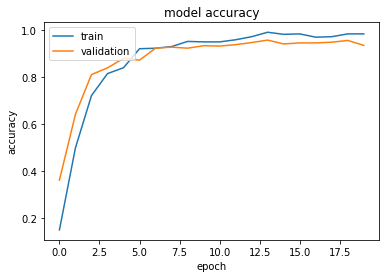

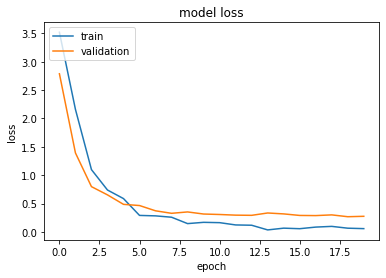

In [17]:
print(cnn_model.history.keys())
#  "Accuracy"
plt.plot(cnn_model.history['accuracy'])
plt.plot(cnn_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(cnn_model.history['loss'])
plt.plot(cnn_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [22]:
def overlay_heatmap(heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_JET):
    # apply the supplied color map to the heatmap and then
    # overlay the heatmap on the input image
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    # return a 2-tuple of the color mapped heatmap and the output,
    # overlaid image
    return heatmap,output

In [18]:
explainer = GradCAM()

In [20]:
heatmap1= explainer.explain((X_validation, Y_validation),model, class_index = 0)

In [26]:
count = 0
for img in X_validation, Y_validation:
    heatmap1= explainer.explain((img, img),model, class_index = 0)
    explainer.save(heatmap1, "explained_imgs", "explainer" + "_" + str(count)+ ".png")
    count+=1
    
    # heatmap2, output = overlay_heatmap(output,img)

ValueError: Input 0 of layer "model_5" is incompatible with the layer: expected shape=(None, 100, 100, 1), found shape=(668, 58)

In [ ]:
heatmap2, output = overlay_heatmap(output,image)

In [21]:
explainer.save(output, ".", "explainer.png")